In [228]:
import pandas as pd
import collections
import digitalhub as dh
from datasets_tourism_dh import *

In [229]:
START_DATE = "2023-07-01"
END_DATE = "2023-09-30"

LOC_ID_COMUNE_MOLVENO = "27"
LOC_TYPE_COMUNE_MOLVENO = "TN_MKT_AL_3"

In [230]:
attendences_df = vodafone_attendences_df[
    (vodafone_attendences_df['date'] >= START_DATE) &
    (vodafone_attendences_df['date'] <= END_DATE) &
    (vodafone_attendences_df["value"] != 0) &
    (vodafone_attendences_df["userProfile"] != 'INHABITANT') &
    (vodafone_attendences_df["userProfile"] != 'COMMUTER') &
    (vodafone_attendences_df["locId"] == LOC_ID_COMUNE_MOLVENO) &
    (vodafone_attendences_df["locType"] == LOC_TYPE_COMUNE_MOLVENO) ]
attendences_df = attendences_df[['date','userProfile','value']]
attendences_df

,date,userProfile,value
2977735,2023-07-01,TOURIST,18
2977736,2023-07-01,VISITOR,18
2977744,2023-07-01,TOURIST,108
2977745,2023-07-01,VISITOR,36
2977746,2023-07-01,TOURIST,216
...,...,...,...
3619685,2023-09-30,TOURIST,929
3619686,2023-09-30,VISITOR,1358
3619697,2023-09-30,TOURIST,25
3619698,2023-09-30,VISITOR,25


In [231]:
tourist_attendences_df = attendences_df[attendences_df['userProfile'] == "TOURIST"][['date','value']].groupby('date').sum()
tourist_attendences_df['weakday'] = pd.to_datetime(tourist_attendences_df.index).weekday
tourist_attendences_df

,value,weakday
date,,
2023-07-01,2924,5
2023-07-02,2987,6
2023-07-03,2544,0
2023-07-04,2547,1
2023-07-05,2762,2
...,...,...
2023-09-26,1183,1
2023-09-27,1070,2
2023-09-28,1083,3


In [232]:
excursionist_attendences_df = attendences_df[attendences_df['userProfile'] == "VISITOR"][['date','value']].groupby('date').sum()
excursionist_attendences_df['weakday'] = pd.to_datetime(excursionist_attendences_df.index).weekday
excursionist_attendences_df

,value,weakday
date,,
2023-07-01,1944,5
2023-07-02,4300,6
2023-07-03,2413,0
2023-07-04,1958,1
2023-07-05,2167,2
...,...,...
2023-09-26,763,1
2023-09-27,899,2
2023-09-28,1089,3


# Meteo 

In [233]:
FEATURE = "probprec06-12" #"meteo" #"intprec06-12" #"probprec12-18" # probprec06-12

In [248]:
ambiti = meteotrentino_bollettino_df["ambito"].unique()
comuni = meteotrentino_bollettino_df["comune"].unique()
print(f"ambiti: {ambiti}")
print(f"comuni: {comuni}")

ambiti: ['TRENTO' 'MADONNA' 'FIEMME' 'ALTIPIANO' 'VALDINON' 'DOLOMITI' 'VALSUGANA'
 'GARDA' 'ROVERETO' None 'SMARTINO' 'VALDISOLE']
comuni: ["BASELGA DI PINE'" 'CANAZEI' 'CAVALESE' 'FOLGARIA' 'FONDO' "MALE'"
 'MEZZOLOMBARDO' 'MOLVENO' 'PERGINE VALSUGANA' 'PINZOLO' 'RIVA DEL GARDA'
 'ROVERETO' "SANT'ORSOLA" 'TIONE DI TRENTO' 'TRENTO' 'COMANO TERME'
 'BEZZECCA' 'PIEVE DI BONO' 'CENTA SAN NICOLO' 'SAN MARTINO DI CASTROZZA'
 'ARCO' 'MEZZANO']


In [290]:
# Weather nearby Molveno
meteo_comune_near_molveno = meteotrentino_bollettino_df[
    ((meteotrentino_bollettino_df["comune"] == "TRENTO") |
     (meteotrentino_bollettino_df["comune"].str.contains("MEZZOLOMBARDO")) |
     (meteotrentino_bollettino_df["comune"].str.contains("PERGINE VALSUGANA"))
     ) & (meteotrentino_bollettino_df["data"] >= START_DATE) &
         (meteotrentino_bollettino_df["data"] <= END_DATE)
]

In [389]:
# Weather in Molveno
meteo_df = meteotrentino_bollettino_df[
    (meteotrentino_bollettino_df["comune"].str.contains("MOLVENO")) &
    (meteotrentino_bollettino_df["data"] >= START_DATE) &
    (meteotrentino_bollettino_df["data"] <= END_DATE)
][['data', FEATURE]].set_index('data')
meteo_molveno_df = meteo_df.reset_index()

## Data imputation
Fill in the missing values of weather with the values taken from comune near Molveno

In [390]:
meteo_df.shape

(52, 1)

In [391]:
comune_near_importance_order = ["MEZZOLOMBARDO", "PERGINE VALSUGANA", "TRENTO"]
# format the categorical data 
meteo_comune_near_molveno["comune"] = pd.Categorical(meteo_comune_near_molveno["comune"], categories = comune_near_importance_order)
meteo_comune_near_molveno = meteo_comune_near_molveno.sort_values(by = "comune")

In [392]:
missing_dates = set(meteo_comune_near_molveno["data"]) - set(meteo_df.index)
missing_dates

{'2023-07-02',
 '2023-07-03',
 '2023-08-16',
 '2023-09-07',
 '2023-09-23',
 '2023-09-26'}

In [393]:
filled_missing_dates = []
for curr_date in missing_dates:    
    rows = meteo_comune_near_molveno[meteo_comune_near_molveno["data"] == curr_date]
    rows = rows.sort_values(by = "comune")
    filled_missing_dates.append({"data": rows.iloc[0, :].to_dict()["data"],
                        "probprec06-12": rows.iloc[0, :].to_dict()["probprec06-12"]})
filled_missing_dates = pd.DataFrame(data=filled_missing_dates)
filled_missing_dates

,data,probprec06-12
0,2023-09-07,--
1,2023-09-23,molto bassa
2,2023-07-03,bassa
3,2023-08-16,molto bassa
4,2023-09-26,--
5,2023-07-02,molto bassa


In [394]:
def data_imputation_weather(nearby_weather, target_weather):
    """
    Filling in missing weather data for specific  days
    """
    missing_dates = set(nearby_weather["data"]) - set(target_weather.index)
    comune_near_importance_order = ["MEZZOLOMBARDO", "PERGINE VALSUGANA", "TRENTO"]
    # format the categorical data 
    nearby_weather["comune"] = pd.Categorical(nearby_weather["comune"], categories = comune_near_importance_order)
    nearby_weather = nearby_weather.sort_values(by = "comune")
    filled_missing_dates = []
    for curr_date in missing_dates:    
        rows = nearby_weather[nearby_weather["data"] == curr_date]
        rows = rows.sort_values(by = "comune")
        filled_missing_dates.append({"data": rows.iloc[0, :].to_dict()["data"],
                            "probprec06-12": rows.iloc[0, :].to_dict()["probprec06-12"]})
    filled_missing_dates = pd.DataFrame(data=filled_missing_dates)
    return filled_missing_dates
resulting_data = data_imputation_weather(meteo_comune_near_molveno, meteo_df)
resulting_data = resulting_data.set_index("data")

In [397]:
meteo_df2 = pd.concat([meteo_df, resulting_data], axis=0)
meteo_df2.shape

(58, 1)

In [240]:
freq = dict(collections.Counter(meteo_df[FEATURE].values))
freq.pop('--')

size = sum(freq.values())
meteo_dist = { k: v/size for k,v in freq.items() }

meteo_dist

{'media': 0.057692307692307696,
 'molto bassa': 0.5,
 'bassa': 0.15384615384615385,
 '--': 0.23076923076923078,
 'alta': 0.057692307692307696}

In [176]:
tourist_attendences_meteo_df = pd.merge(tourist_attendences_df, meteo_df, how='outer', left_index=True, right_index=True).fillna('--')
tourist_attendences_meteo_df

,value,weakday,meteo
2023-07-01,2924,5,Molto nuvoloso con piogge deboli
2023-07-02,2987,6,--
2023-07-03,2544,0,--
2023-07-04,2547,1,Nuvoloso
2023-07-05,2762,2,--
...,...,...,...
2023-09-26,1183,1,--
2023-09-27,1070,2,--
2023-09-28,1083,3,--
2023-09-29,1526,4,Sereno


In [177]:
excursionist_attendences_meteo_df = pd.merge(excursionist_attendences_df, meteo_df, how='outer', left_index=True, right_index=True).fillna('--')
excursionist_attendences_meteo_df

,value,weakday,meteo
2023-07-01,1944,5,Molto nuvoloso con piogge deboli
2023-07-02,4300,6,--
2023-07-03,2413,0,--
2023-07-04,1958,1,Nuvoloso
2023-07-05,2167,2,--
...,...,...,...
2023-09-26,763,1,--
2023-09-27,899,2,--
2023-09-28,1089,3,--
2023-09-29,703,4,Sereno


In [178]:
def compute_stats(attendences_meteo_df):
    presences_stats = {}
    
    sample = attendences_meteo_df[['value']]
    (mean, std) = (sample.mean().value, sample.std().value)
    presences_stats[-1, "*"] = {'mean':mean, 'std':std}
    
    for w in range(7):
        sample = attendences_meteo_df[attendences_meteo_df['weakday']==w][['value']]
        (mean, std) = (sample.mean().value, sample.std().value)
        presences_stats[w, "*"] = {'mean':mean, 'std':std}
        
    for p in attendences_meteo_df[FEATURE].unique():
        if p == '--': continue
        sample = attendences_meteo_df[attendences_meteo_df[FEATURE]==p][['value']]
        (mean, std) = (sample.mean().value, sample.std().value)
        presences_stats[-1, p] = {'mean':mean, 'std':std}
        
        for w in range(7):
            sample = attendences_meteo_df[(attendences_meteo_df['weakday']==w) &
                 (attendences_meteo_df[FEATURE]==p)][['value']]
            if len(sample) == 0:
                (mean, std) = ((presences_stats[w, '*']['mean'] + presences_stats[-1,p]['mean']) * 0.5,
                               (presences_stats[w, '*']['std'] * presences_stats[-1,p]['std']) ** 0.5)
            elif len(sample) == 1:
                (mean, std) =  (sample.mean().value,
                                (presences_stats[w, '*']['std'] * presences_stats[-1,p]['std']) ** 0.5)
            else:
                (mean, std) = (sample.mean().value, sample.std().value)
            presences_stats[w, p] = {'mean':mean, 'std':std}
    
    return presences_stats

In [179]:
tourist_presences_stats = compute_stats(tourist_attendences_meteo_df)
tourist_presences_stats

{(-1, '*'): {'mean': 3292.75, 'std': 1127.9532044010873},
 (0, '*'): {'mean': 3037.4615384615386, 'std': 1171.188258094076},
 (1, '*'): {'mean': 2945.230769230769, 'std': 1117.096247259396},
 (2, '*'): {'mean': 3031.4615384615386, 'std': 1151.6471258871368},
 (3, '*'): {'mean': 3136.4615384615386, 'std': 1167.2054671582473},
 (4, '*'): {'mean': 3361.230769230769, 'std': 994.882920569564},
 (5, '*'): {'mean': 3858.5, 'std': 1151.389511717172},
 (6, '*'): {'mean': 3635.3846153846152, 'std': 1051.836927986902},
 (-1, 'Molto nuvoloso con piogge deboli'): {'mean': 3111.0,
  'std': 264.45793616376875},
 (0, 'Molto nuvoloso con piogge deboli'): {'mean': 3074.2307692307695,
  'std': 556.5339428954884},
 (1, 'Molto nuvoloso con piogge deboli'): {'mean': 3298.0,
  'std': 543.5300985653978},
 (2, 'Molto nuvoloso con piogge deboli'): {'mean': 3071.2307692307695,
  'std': 551.871563048005},
 (3, 'Molto nuvoloso con piogge deboli'): {'mean': 3123.7307692307695,
  'std': 555.5868509276814},
 (4, 'Mol

In [180]:
excursionist_presences_stats = compute_stats(excursionist_attendences_meteo_df)
excursionist_presences_stats

{(-1, '*'): {'mean': 3198.0760869565215, 'std': 1849.4465714155635},
 (0, '*'): {'mean': 2830.0, 'std': 2083.9047483030504},
 (1, '*'): {'mean': 2861.0, 'std': 2259.344189508687},
 (2, '*'): {'mean': 2746.230769230769, 'std': 1543.493070594863},
 (3, '*'): {'mean': 2810.3076923076924, 'std': 1691.1208011560157},
 (4, '*'): {'mean': 2940.153846153846, 'std': 1752.114714954182},
 (5, '*'): {'mean': 3690.5, 'std': 1471.7294771275576},
 (6, '*'): {'mean': 4470.461538461538, 'std': 1752.059388994592},
 (-1, 'Molto nuvoloso con piogge deboli'): {'mean': 1952.5,
  'std': 12.020815280171307},
 (0, 'Molto nuvoloso con piogge deboli'): {'mean': 2391.25,
  'std': 158.2726572747891},
 (1, 'Molto nuvoloso con piogge deboli'): {'mean': 1961.0,
  'std': 164.80036151784464},
 (2, 'Molto nuvoloso con piogge deboli'): {'mean': 2349.3653846153848,
  'std': 136.21323389394018},
 (3, 'Molto nuvoloso con piogge deboli'): {'mean': 2381.403846153846,
  'std': 142.5785775183347},
 (4, 'Molto nuvoloso con piogg

In [181]:
from scipy.stats import truncnorm

In [182]:
tourist_sample_w = {}
excursionist_sample_w = {}
sample_size = 100

for w in range(-1,7):
    stats = tourist_presences_stats[w,'*']
    tourist_sample_w[w] = truncnorm.rvs(-stats['mean'] / stats['std'], 10, loc=stats['mean'], scale=stats['std'], size=sample_size)
    stats = excursionist_presences_stats[w,'*']
    excursionist_sample_w[w] = truncnorm.rvs(-stats['mean'] / stats['std'], 10, loc=stats['mean'], scale=stats['std'], size=sample_size)

In [183]:
import matplotlib.pyplot as plt

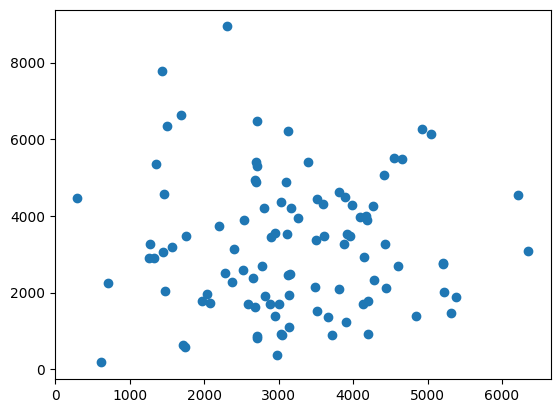

In [184]:
plt.scatter(tourist_sample_w[-1], excursionist_sample_w[-1]);

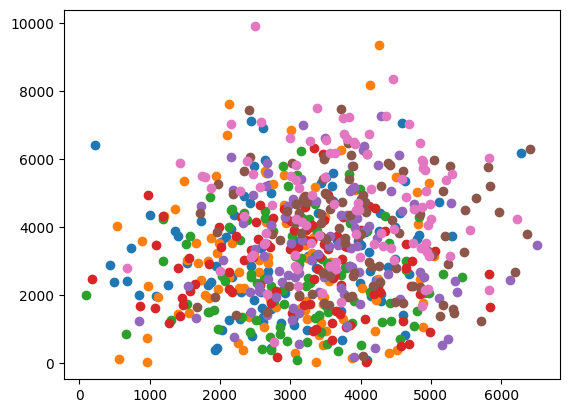

In [185]:
for w in range(7):
    plt.scatter(tourist_sample_w[w], excursionist_sample_w[w]);

In [186]:
tourist_sample_p = {}
excursionist_sample_p = {}
sample_size = 100

for p in meteo_dist.keys():
    stats = tourist_presences_stats[-1, p]
    tourist_sample_p[p] = truncnorm.rvs(-stats['mean'] / stats['std'], 10, loc=stats['mean'], scale=stats['std'], size=sample_size)
    stats = excursionist_presences_stats[-1, p]
    excursionist_sample_p[p] = truncnorm.rvs(-stats['mean'] / stats['std'], 10, loc=stats['mean'], scale=stats['std'], size=sample_size)

ValueError: Domain error in arguments. The `scale` parameter must be positive for all distributions, and many distributions have restrictions on shape parameters. Please see the `scipy.stats.truncnorm` documentation for details.

KeyError: 'Molto nuvoloso'

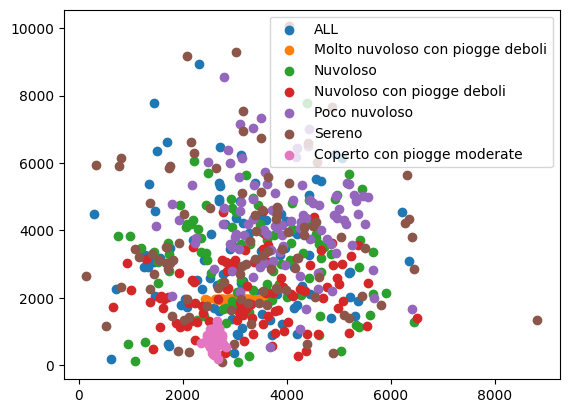

In [187]:
plt.scatter(tourist_sample_w[-1], excursionist_sample_w[-1], label='ALL')
for p in meteo_dist.keys():
    plt.scatter(tourist_sample_p[p], excursionist_sample_p[p], label=p)
    plt.legend()

In [188]:
meteo_dist

{'Molto nuvoloso con piogge deboli': 0.038461538461538464,
 'Nuvoloso': 0.15384615384615385,
 'Nuvoloso con piogge deboli': 0.1346153846153846,
 'Poco nuvoloso': 0.40384615384615385,
 'Sereno': 0.21153846153846154,
 'Coperto con piogge moderate': 0.038461538461538464,
 'Molto nuvoloso': 0.019230769230769232}